<div class="alert alert-success">
<b>Комментарий ревьюера 2:</b> Супер, всегда рада помочь 😊 
    
Вопрос, наверное, не совсем для меня. Базу я получила в университете по лекциям (можно найти записи университетских лекций на ютубе и на сайтах известных университетов), а все дальнейшее развитие - чисто практика. То есть я не читала каких-то книг полноценно и целенаправленно, скорее как только сталкивалась с чем-то непонятным или незнакомым, конкретно под этот актуальный на данный момент вопрос искала информацию. 

**Импорт библиотек:**

In [1]:
import pandas as pd

import missingno as msno

import re

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns

import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import numpy as np

from lightgbm import LGBMRegressor

from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

import time

from catboost import CatBoostRegressor

pd.set_option('display.max_colwidth', None)

## Подготовка данных

### Загрузка и предпросмотр

In [2]:
 try:
        df = pd.read_csv('autos.csv', parse_dates=['DateCrawled'])
 except FileNotFoundError:
        df = pd.read_csv('datasets/autos.csv', parse_dates=['DateCrawled'])
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


Визуально таблицу видим, рассмотрим ее подробнее, чтобы сделать первые выводы. Для этого используем функцию, которая сразу покажет всю, интересующую нас информацию о строении таблицы:

In [3]:
# функция для ознакомления с таблицами
def observe_data(df):
    print('Превью таблицы (первые пять строк):\n')
    display(df.head())
    print('=' * 90)
    print('Информация о столбцах и типах данных:\n')
    df.info()
    print('=' * 90)
    print('Статистическая информация:\n')
    display(df.describe().T)

In [4]:
observe_data(df)

Превью таблицы (первые пять строк):



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  object        
 13  Numbe

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
RegistrationYear,354369.0,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Power,354369.0,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Kilometer,354369.0,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,1067.0,30165.0,49413.0,71083.0,99998.0,25783.096248


Первые выводы о датасете:
+ Исходный датасет имеет 354369 наблюдений по 16 признакам. 
+ Несоответствия количества строк по признакам говорит нам о наличии пропусков. 
+ Типов данных всего два: int64 и object. В таблице есть признаки с явным указанием на даты, такие как `DateCrawled` или `LastSeen`, значит есть проблемы и с несоответствием типов данных. 
+ В статистической информации мы видим наличие аномальных нулевых значение в таких столбцах как `Price` или `Power`. 
+ Дополнительно можно сказать об отклонение от общепринятых стандартах в названиях столбцов.

Покажем визуально пропуски датасета:

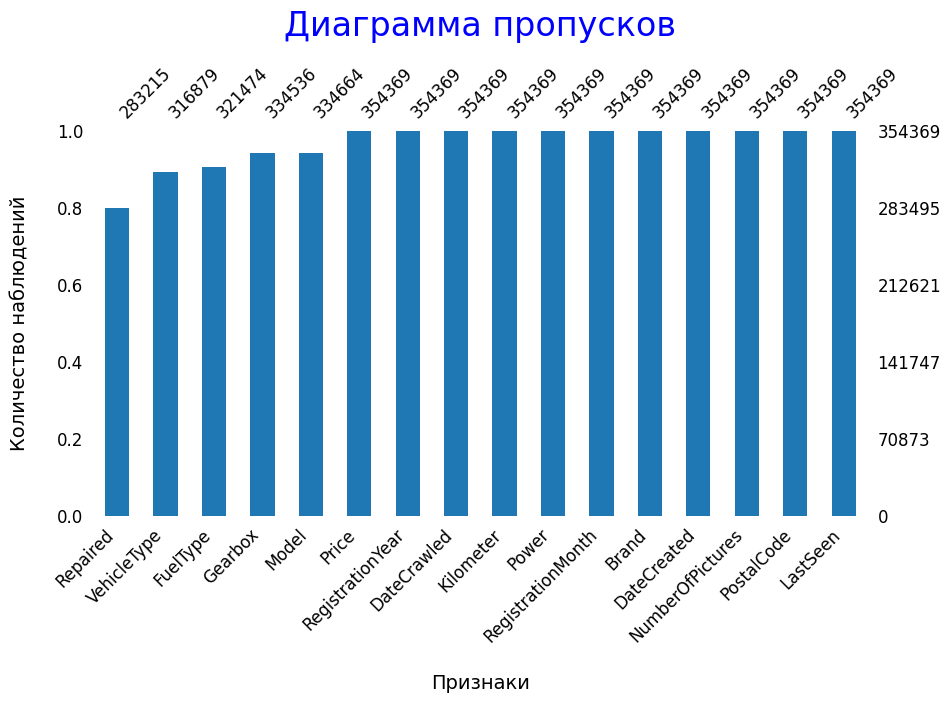

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
msno.bar(df, ax=ax, fontsize=12, sort="ascending", color="tab:blue")
ax.set_title('Диаграмма пропусков', fontsize=24, color='blue', pad=20)
ax.set_xlabel('Признаки', fontsize=14, labelpad=20)
ax.set_ylabel('Количество наблюдений', fontsize=14, labelpad=20)
plt.show()

Всех больше пропусков имеет признак `Repaired` - 71154. 

### Предобработка данных

#### Неверный тип данных

Проблему с неправильным определением типа *datetime* решим на этапе парсирования данных:

In [6]:
date_cols = ['DateCrawled', 'DateCreated', 'LastSeen']
try:
        df = pd.read_csv('/datasets/autos.csv', parse_dates=date_cols)
except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=date_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Дата теперь стала датой. Посмотрим на имена столбцов.

#### Переименование столбцов

In [7]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Нам нужно все буквы сделать строчными, а перед каждой второй и последующими заглавными поставить символ подчеркивания. Применим регулярные выражения:

In [8]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Удаление неинформативных признаков

Перед дальнейшей работой разберемся со столбцом `number_of_pictures`. Статистика указала, что все значения нулевые.

In [9]:
df['number_of_pictures'].unique()

array([0])

Это константный признак говорит о том, что все объекты не имеют фотографий, не является информативным для нас. Удалим его.

In [10]:
df.drop('number_of_pictures', axis=1, inplace=True)

#### Устранение пропусков

Теперь можно вернуться к проблеме с пропусками:

In [11]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
postal_code               0
last_seen                 0
dtype: int64

Все признаки с пропусками имеют строковую информацию. Причем информация о кузове, модели авто, наличия факта ремонта является определяющей для цены. Для начала поставим заглушку `unknown` на месте пропусков признака `repaired`. Остальные признаки заполним наиболее часто встречаемыми значениями в категории, в противном случае тоже поставим заглушку.

In [12]:
# missing_cols = df.columns[df.isna().sum() > 0].tolist()
# df[missing_cols] = df[missing_cols].fillna('unknown')
# df.isna().sum()

In [13]:
missing_cols = df.columns[df.isna().sum() > 0].tolist()
missing_cols

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

In [14]:
df['repaired'] = df['repaired'].fillna('unknown')

In [15]:
df['model'] = df.groupby('brand')['model'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown')
)
df['model'][df['model'] == 'unknown'].count()

3374

In [16]:
for column in df.columns[df.isna().sum() > 0].tolist():
    
    df[column] = df.groupby('model')[column].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown')
)

#### Устранение дубликатов

In [17]:
df.duplicated().sum()

4

In [18]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0


В этом подразделе исправили следующие проблемы:
+ считывание дат, теперь они имеют тип *datetime*;
+ названия столбцов поменяли на корректные;
+ все пропуски заменили на заглушку;
+ устранили явные дубликаты.

Проверку на неявные дубликаты и выявление и устранение аномальных значение проведем попутно с исследованием данных.

### Исследовательский анализ

Все данные можно разделить на количественные, категориальные и временные. Рассмотрим количественные (включим в рассмотрение и категориальные столбцы `registration_year`, `postal_code`):

#### Количественные данные

In [19]:
num_cols = df.select_dtypes(include='int').drop(['registration_month'], axis=1).columns
num_cols

Index(['price', 'registration_year', 'power', 'kilometer', 'postal_code'], dtype='object')

Рассмотрим и удалим сначала все аномалии, потом построим гистограмму распределения и диаграмму размаха количественных признаков.

In [20]:
df['price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [21]:
df[df['price'] == 0].shape

(10772, 15)

Свыше 10000 автомобилей судя по таблице раздают бесплатно, нужно отфильтровать этот столбец.

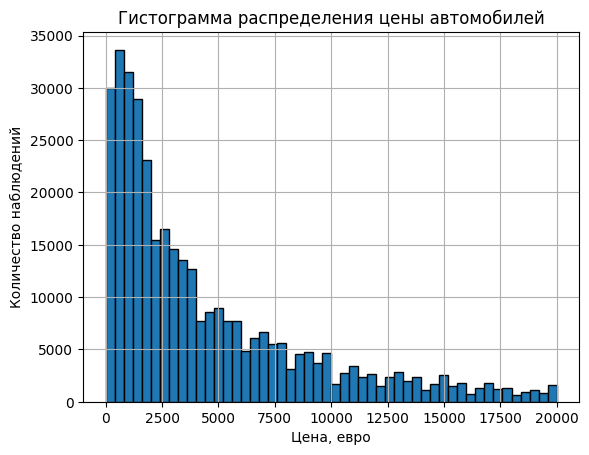

In [22]:
df['price'].hist(bins=50, edgecolor='black', grid=True)
plt.xlabel('Цена, евро')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения цены автомобилей')
plt.show()

Подробней рассмотрим цену вблизи нуля, чтобы определить порог фильтра.

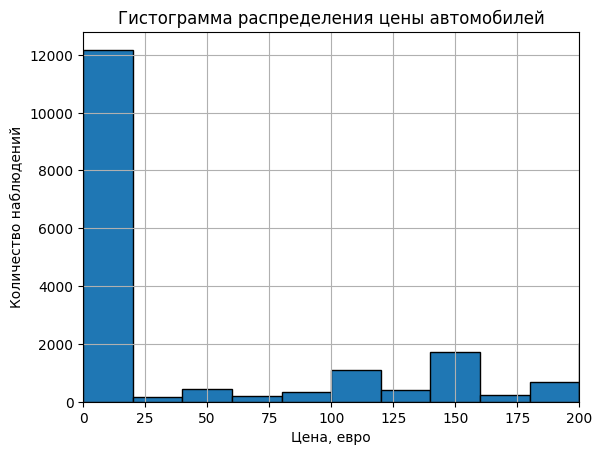

In [23]:
df['price'].hist(bins=1000, edgecolor='black', grid=True)
plt.xlim(0, 200)
plt.xlabel('Цена, евро')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения цены автомобилей')
plt.show()

In [24]:
df.loc[df['price'] < 25].head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,small,1990,manual,0,corsa,150000,1,petrol,opel,unknown,2016-03-26,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,unknown,150000,11,petrol,sonstige_autos,unknown,2016-03-29,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,sedan,2017,manual,0,golf,5000,12,petrol,volkswagen,unknown,2016-03-19,21698,2016-04-01 08:47:05


Слабо верится, что мерседес можно приобрести за 1 евро. Отфильтруем машины по цены, превышающие 25 евро, т.к. до этой цены мы наблюдаем 

In [25]:
df = df.loc[df['price'] > 25]

In [26]:
df.shape

(342102, 15)

Теперь рассмотрим год регистрации авто.

In [27]:
df['registration_year'].describe()

count    342102.000000
mean       2004.084372
std          77.242543
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

Здесь тоже что-то не в порядке с годами, есть машины из далекого прошлого или будущего.

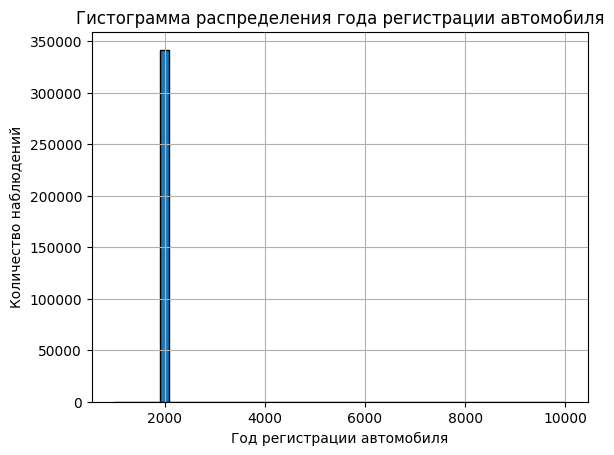

In [28]:
df['registration_year'].hist(bins=50, edgecolor='black', grid=True)
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения года регистрации автомобиля');

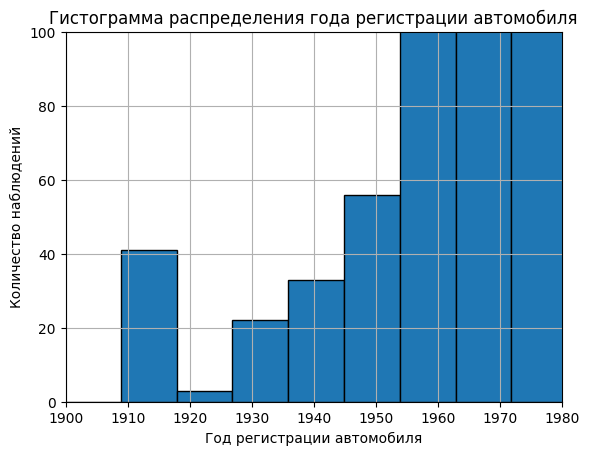

In [29]:
df['registration_year'].hist(bins=1000, edgecolor='black', grid=True)
plt.xlim(1900, 1980)
plt.ylim(0, 100)
plt.xlabel('Год регистрации автомобиля')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения года регистрации автомобиля');

In [30]:
df['last_seen'].max()

Timestamp('2016-04-07 14:58:51')

Видим, что превышать хотя бы 100 единиц, начали машины, зарегестрированные с середины 50-х. Возьмем 1955 за нижнюю границу. А верхней сделаем 2016 год, как максимальный год из временного признака `last_seen`.

In [31]:
df = df.loc[(df['registration_year'] > 1955) & (df['registration_year'] < 2017)]

In [32]:
df.shape

(328171, 15)

Перейдем к признаку, характеризующему мощность.

In [33]:
df['power'].describe()

count    328171.000000
mean        112.131578
std         185.097974
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Машины слабее лошади с одной стороны и сопоставимые по мощности с ракетным двигателем с другой. Явно что-то не так. Отфильтруем этот признак следующим образом: примем, что старые машины могут иметь мощность 10 л.с., а суперкары 2016 года на превышали 2000.

In [34]:
df.loc[(df['power'] < 10) | (df['power'] > 2000)].shape

(32400, 15)

In [35]:
df['power'] = df.groupby('model')['power'].transform(
    lambda x: x.where(((x > 10) & (x < 2000)), x.mode()[0] if not x.mode().empty else x)
)

In [36]:
df.loc[(df['power'] < 10) | (df['power'] > 2000)].shape

(4423, 15)

Удалось заполнить модой почти 28000 значений. Оставшиеся отфильтруем.

In [37]:
df['power'].describe()

count    328171.000000
mean        118.072304
std          62.826180
min           0.000000
25%          75.000000
50%         109.000000
75%         145.000000
max        1999.000000
Name: power, dtype: float64

In [38]:
df = df.loc[(df['power'] > 10) & (df['power'] < 2000)]

In [39]:
df.shape

(323748, 15)

In [40]:
df['kilometer'].describe()

count    323748.000000
mean     128557.643599
std       37010.053376
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Здесь все выглядит правдоподобно, ничего фильтровать не будем.

In [41]:
df.shape

(323748, 15)

Построим граифики количественных признаков. Для этого напишем функцию для построения каждого типа графика:

In [42]:
def make_histogramm(ax, df, column):
    
    ax.hist(x=df[column], bins=30, edgecolor='black')
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    ax.set_title(f'Гистограмма распределения признака {column}')
    ax.set_xlabel('Значение признака')
    ax.set_ylabel('Количество наблюдений')

In [43]:
def make_boxplot(ax, df, column):
    
    ax.boxplot(df[column], vert=False)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    ax.set_title(f'Диаграмма размаха признака {column}')
    ax.set_xlabel('Значение признака')

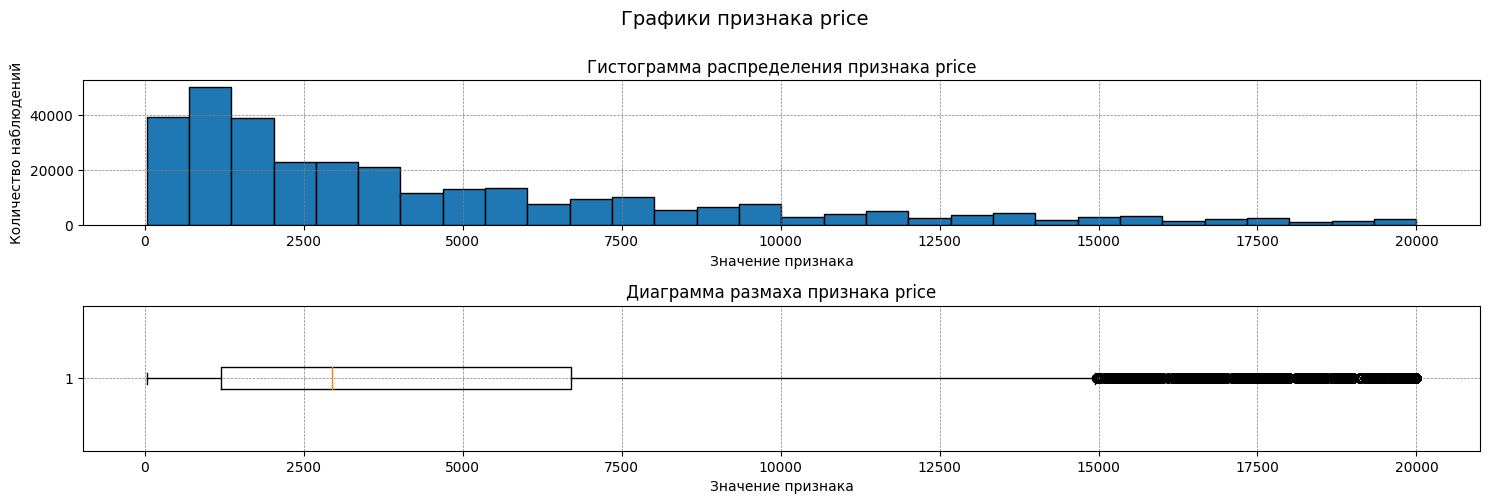

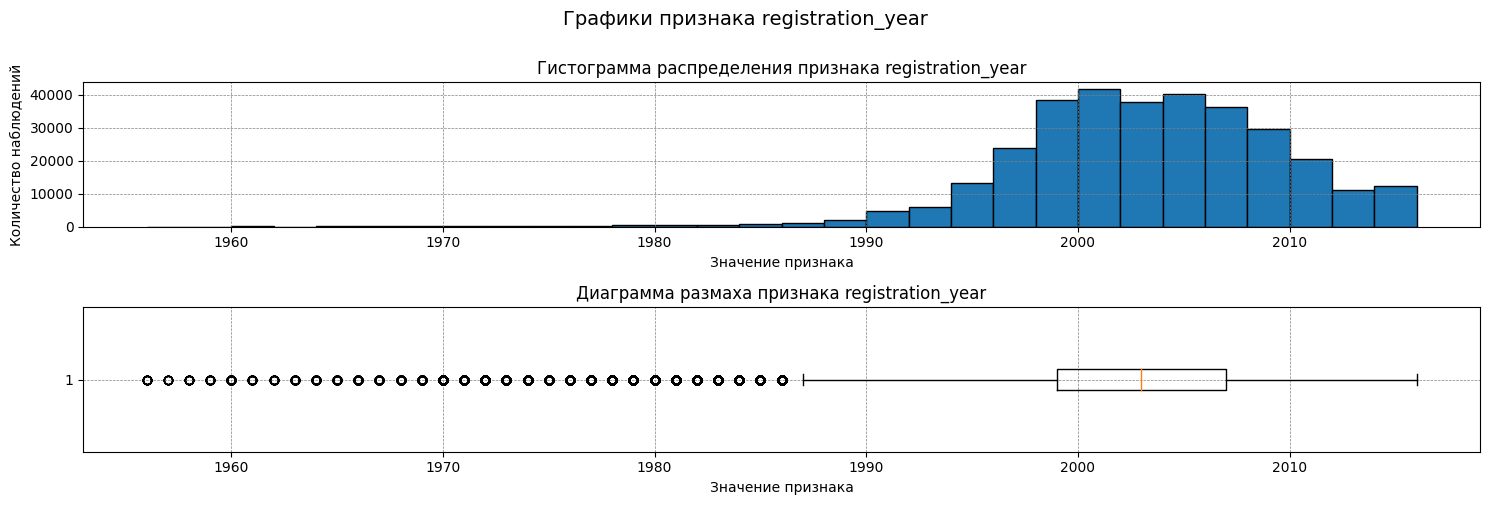

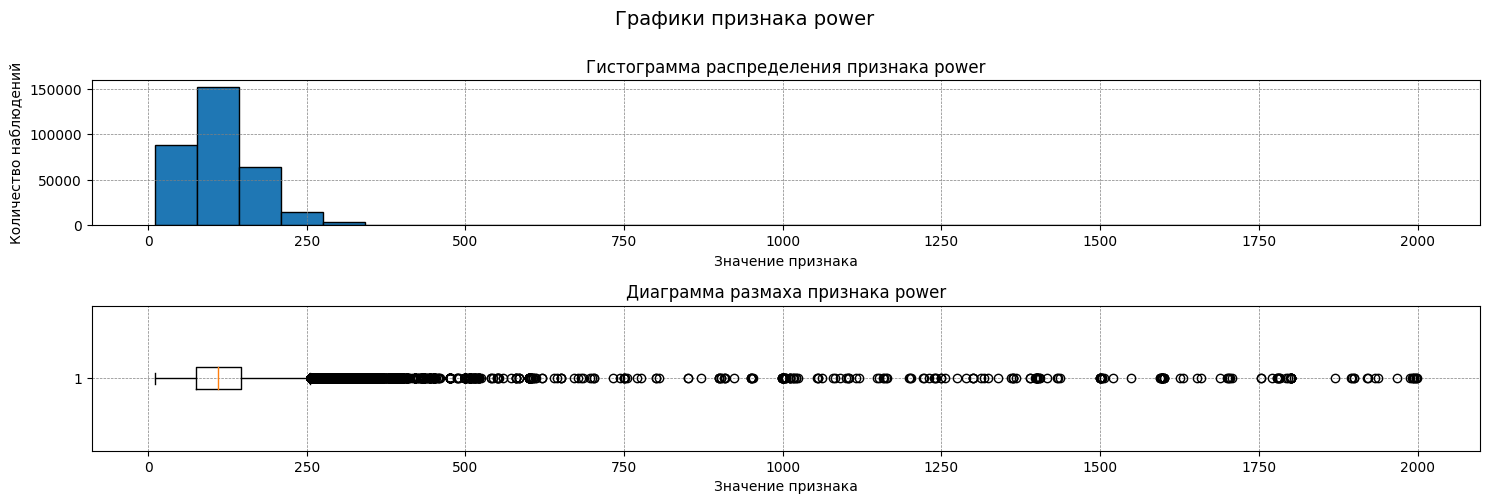

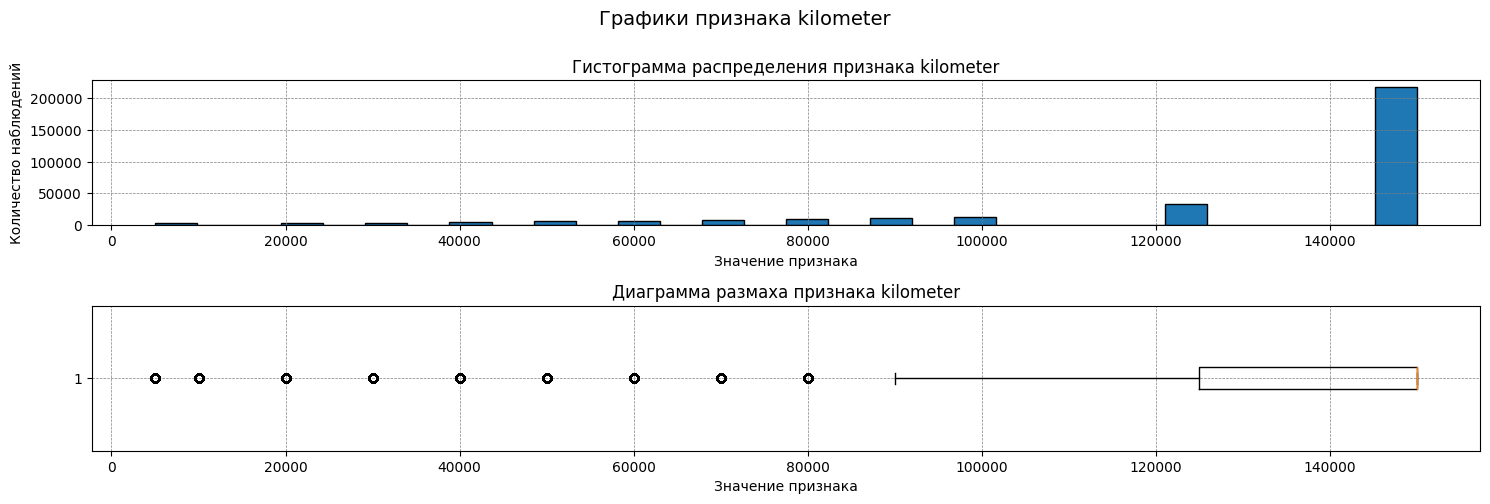

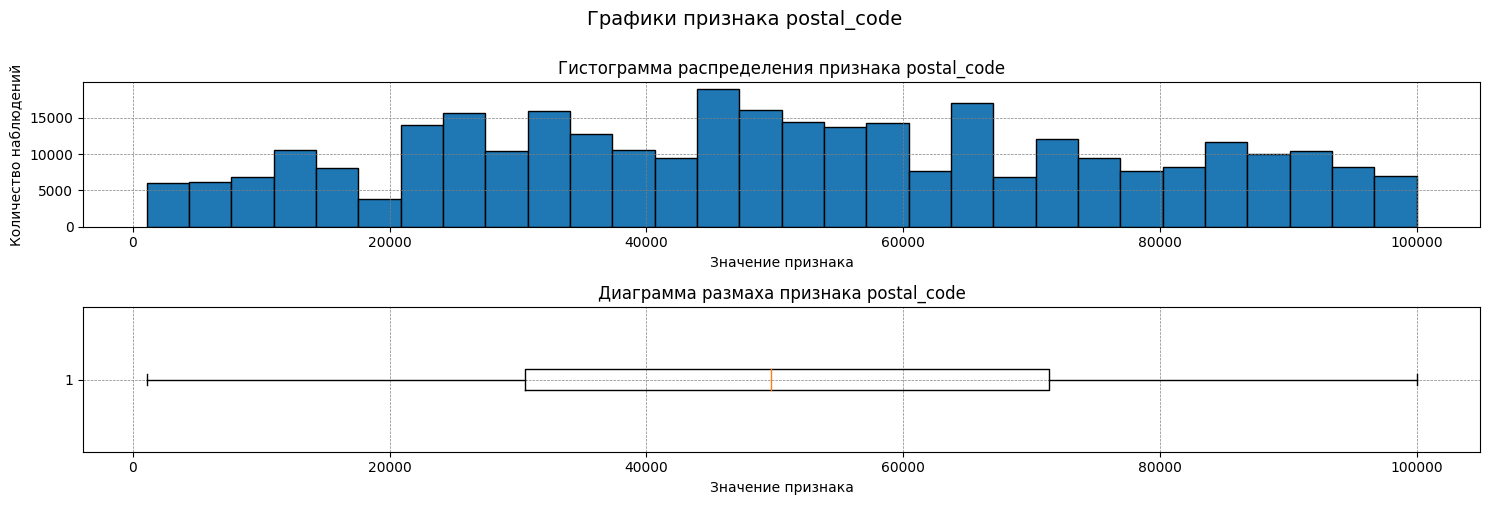

In [44]:
for column in num_cols:
    
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(nrows=2, ncols=1, figure=fig)
    plt.suptitle(f'Графики признака {column}', va='center', fontsize=14)
    

        
    ax = fig.add_subplot(gs[0,0])
    make_histogramm(ax, df, column)
    ax = fig.add_subplot(gs[1,0])
    make_boxplot(ax, df, column)

    plt.tight_layout()
    plt.show()

Посмотрим на тип связи между таргетом и количественными признаками:

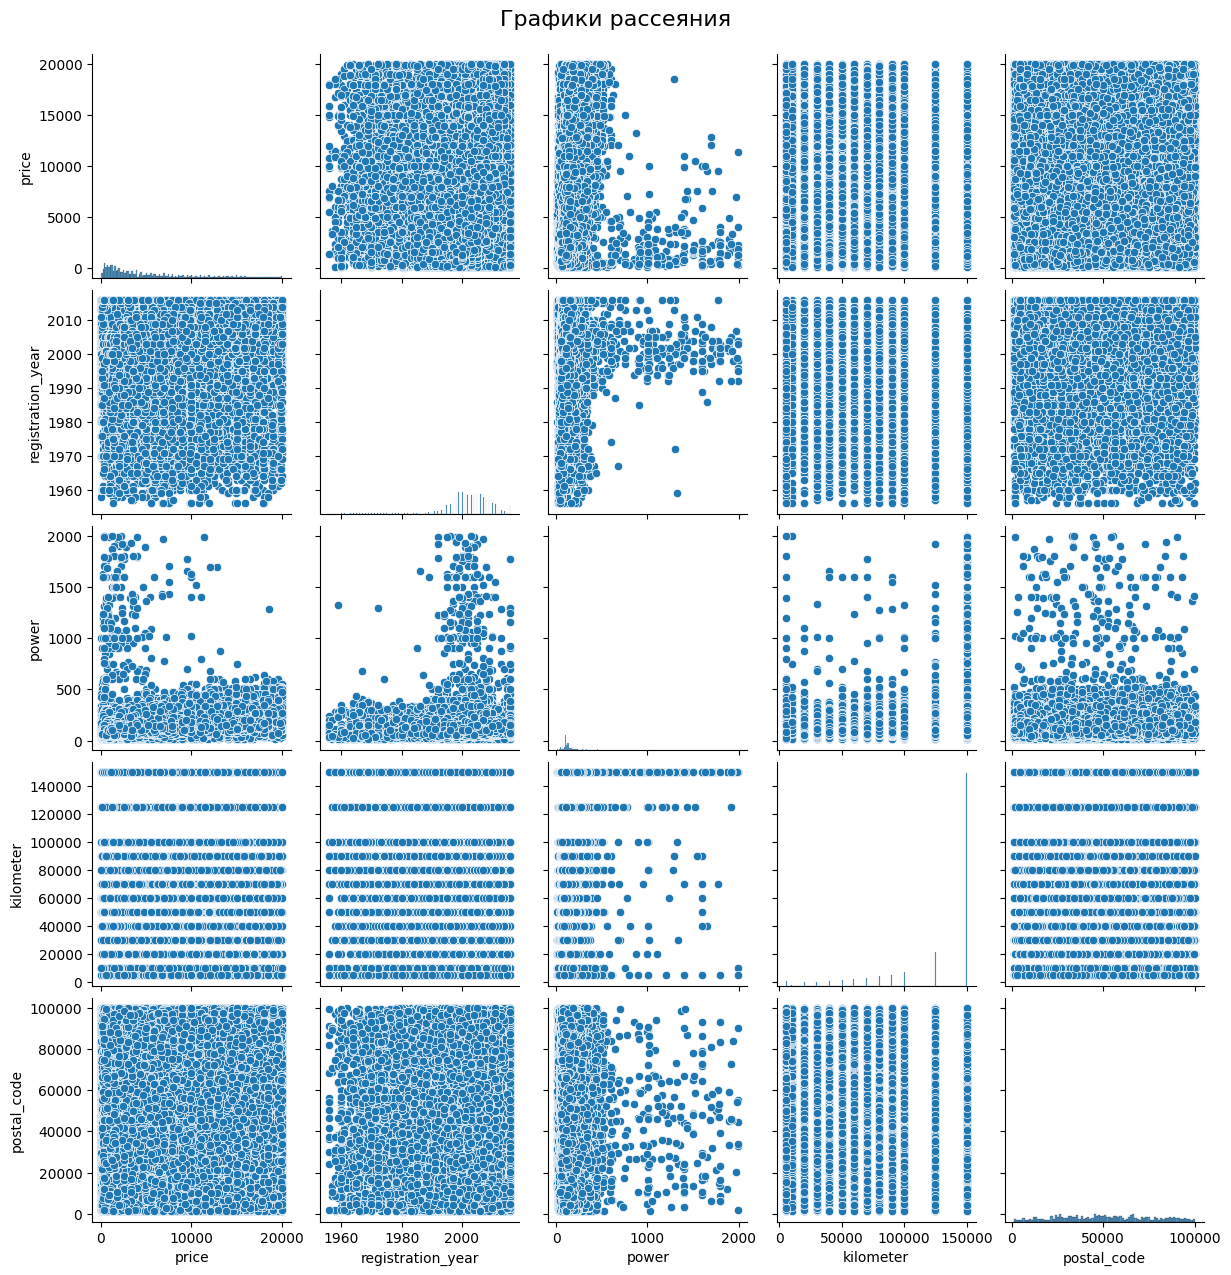

In [45]:
sns.pairplot(df, vars=num_cols)
plt.suptitle(f'Графики рассеяния', y=1.02, fontsize=16)
plt.show()

Целевой признак не имеет линейной связи ни с одним из признаков. 

Резюме по количественным данным:
+ Признак `price` распределен не нормально, имеет выбросы.
+ `registration_year` нормально распределен, имеет выбросы. В среднем представлены автомобили, зарегистрированные после 2000 года.
+ `power` нормально распределен со смещением, есть выбросы.
+ `kilometer` большая часть автомобилей имеет пробег более 140_000 км.
+ `postal_code` географически автомобили распределены нормально.
+ Признаки между собой связаны нелинейно.

#### Категориальные данные

Здесь мы также в начале избавимся от аномалий, а затем построим диаграммы для лучшего понимания данных.

In [46]:
cat_cols = df.drop(num_cols, axis=1).select_dtypes(exclude='datetime64').columns
cat_cols

Index(['vehicle_type', 'gearbox', 'model', 'registration_month', 'fuel_type',
       'brand', 'repaired'],
      dtype='object')

In [47]:
df['vehicle_type'].value_counts()

vehicle_type
sedan          96817
small          82649
wagon          65325
bus            29250
convertible    19752
coupe          15497
suv            11709
other           2749
Name: count, dtype: int64

Не все категории этого признака семантически равнозначны, так, например, непонятно, какой тип кузова представляет категория `other`. 

In [48]:
df['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [49]:
df['model'].unique()

array(['golf', 'a4', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'ka', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio',
       'touareg

Неявных дубликатов здесь не наблюдаем.

In [50]:
df['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

Вероятно какой-то программист-автовладелец за январь поставил 0 месяц. Исправим так, чтобы месяцы были от 1 до 12.

In [51]:
df.loc[df['registration_month'] == 0, 'registration_month'] = 1

In [52]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Видим наименование категорий `petrol` и `gasoline`, что является одним и тем же видом топлива.

In [53]:
df.loc[df['fuel_type'] == 'petrol', 'fuel_type'] = 'gasoline'

In [54]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'trabant', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada'], dtype=object)

In [55]:
df['repaired'].unique()

array(['unknown', 'yes', 'no'], dtype=object)

Неявные дубликаты были выявлены только в столбце `fuel_type`.

Построим диаграммы распределений для наибольших категорий признаков `vehicle_type`, `model`, `brand`:

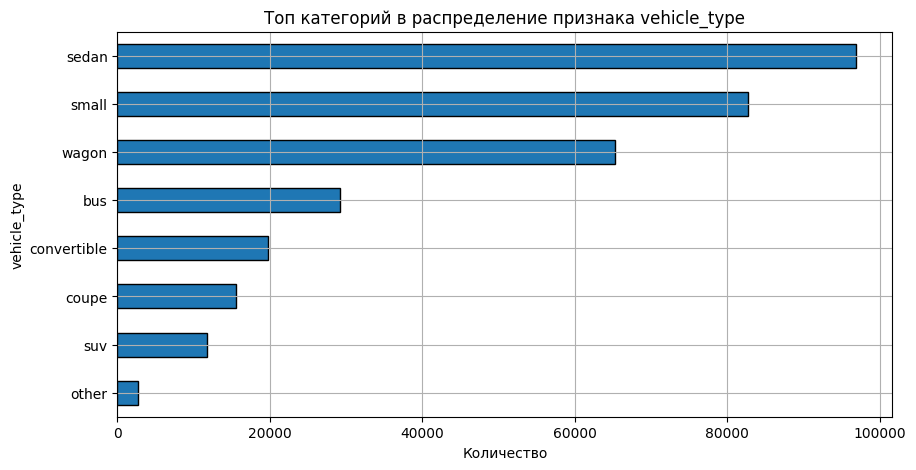

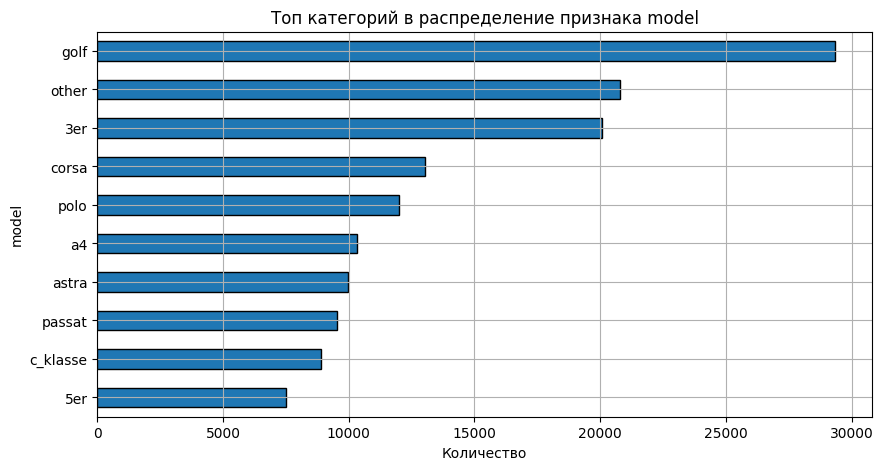

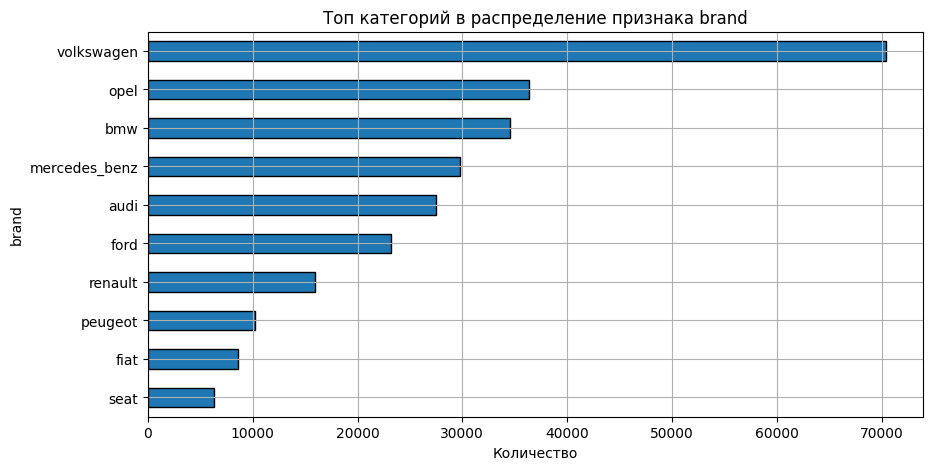

In [56]:
for column in ['vehicle_type', 'model', 'brand']:
    (df[column]
    .value_counts()
    .head(10)
    .sort_values()
    .plot(kind='barh', figsize=(10, 5), edgecolor='black', grid=True)
     )
    
    plt.title(f'Топ категорий в распределение признака {column}')
    plt.ylabel(f'{column}')
    plt.xlabel('Количество')
    plt.show()

В этих же признаках оценим наиболее дорогие (медианные) автомобили: 

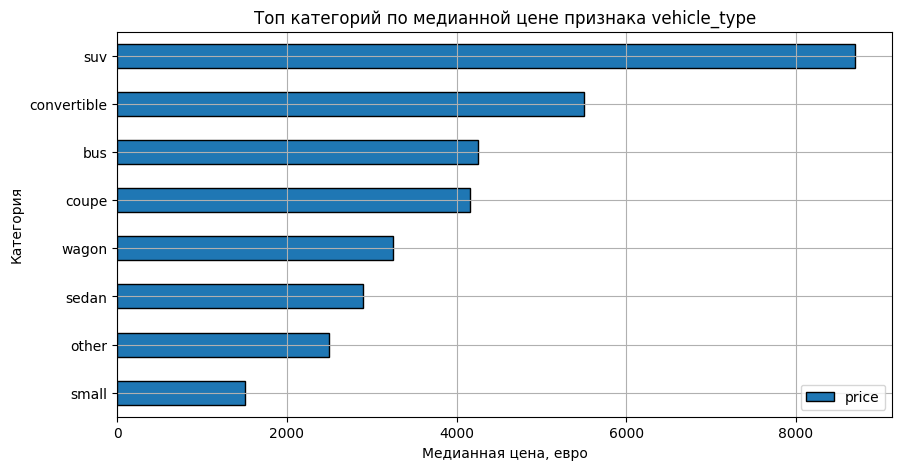

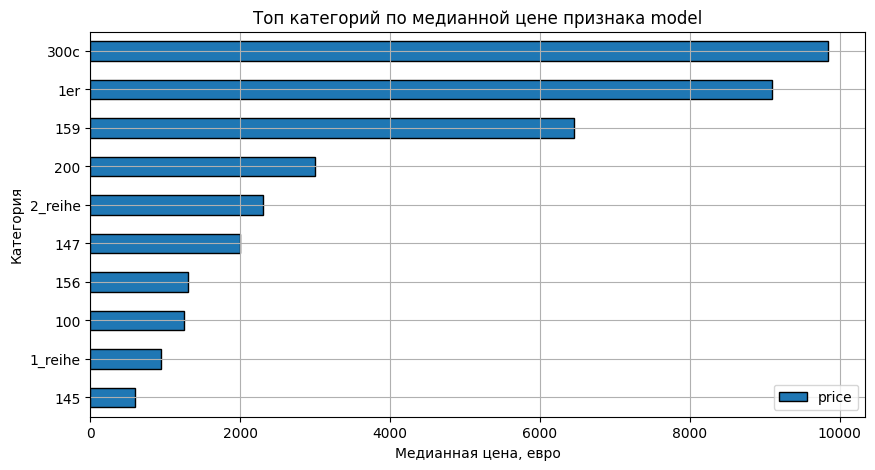

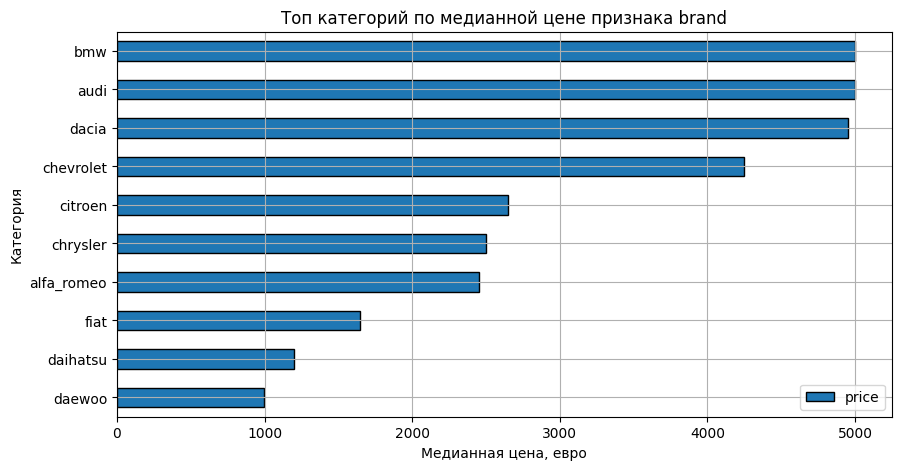

In [57]:
for column in ['vehicle_type', 'model', 'brand']:    
    (df.groupby([column])
         .agg({'price': 'median'})
         .head(10)
         .sort_values(by='price')
         .plot(kind='barh', figsize=(10, 5), edgecolor='black', grid=True)
    )
    plt.title(f'Топ категорий по медианной цене признака {column}')
    plt.ylabel('Категория')
    plt.xlabel('Медианная цена, евро')
    plt.grid(True)
    plt.show()

+ Наиболее востребованными типами кузова - седан, маленький городской, универсал. Наиболее дорогой - внедорожники, кабриолеты.
+ Среди моделей самые распространненые - гольф и бмв третьей модели. Наиболее дорогие: крайслер (300c), бмв(1er) и альфа-ромео(159).
+ Из марок автомобиля было продано больше всех - фольксваген, опель и бмв. Из которых наиболее дорогие по медиане - бмв, ауди и дация.

Построим круговые диаграммы для оставшихся признаков:

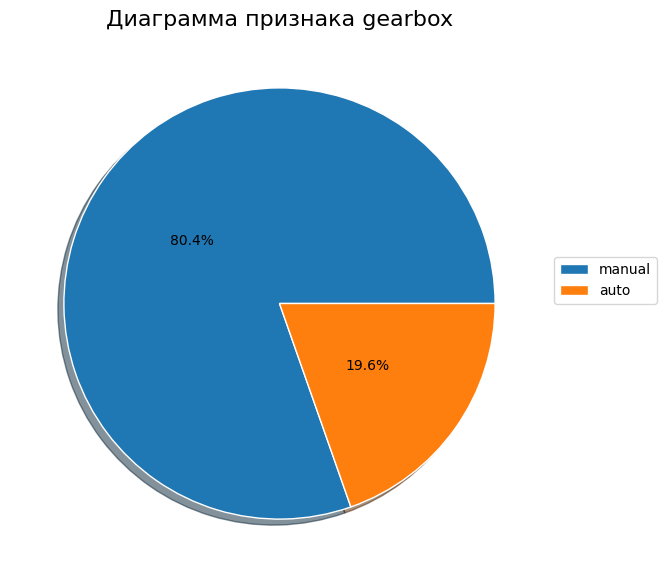

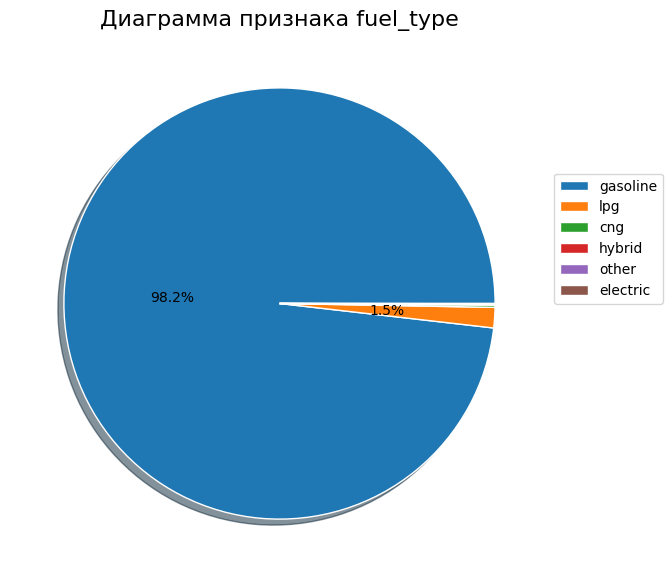

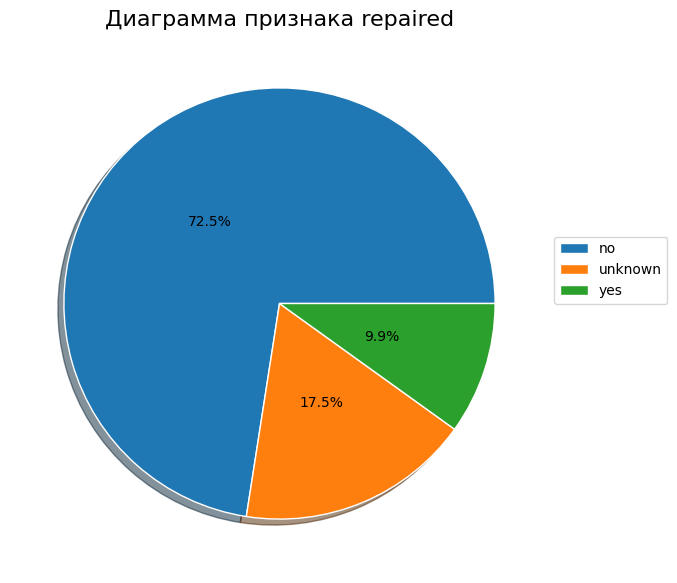

In [58]:
for column in ['gearbox', 'fuel_type', 'repaired']:
    plt.figure(figsize=(7, 7))
    values = df[column].value_counts().values
    labels = df[column].value_counts().index
    plt.pie(
        values,
        wedgeprops={'edgecolor': 'w'},
        shadow=True,
        pctdistance = 0.5,
        autopct=lambda x: f'{x:.1f}%' if x > 1 else ''
    )
    plt.legend(labels=labels, loc=[1.01, 0.5])
    plt.title(f'Диаграмма признака {column}', fontsize=16)
    plt.show()


Также посмотрим, сколько стоят разные категории рассмотренных категориальных признаков. Цены будем рассматривать снова медианные.

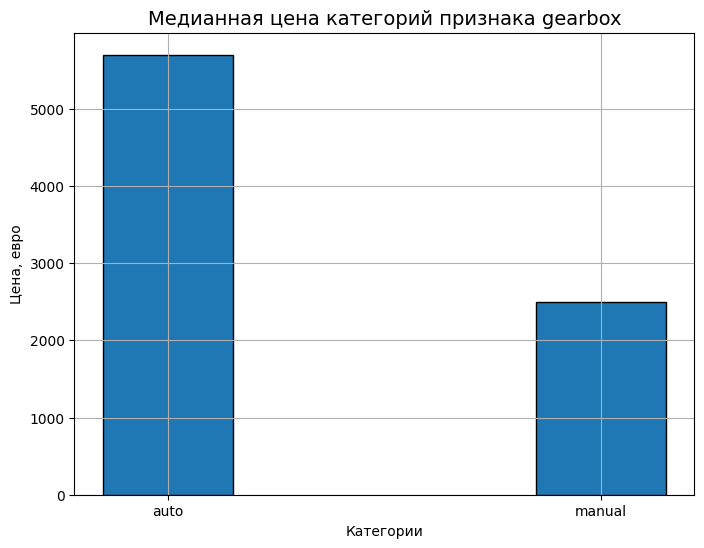

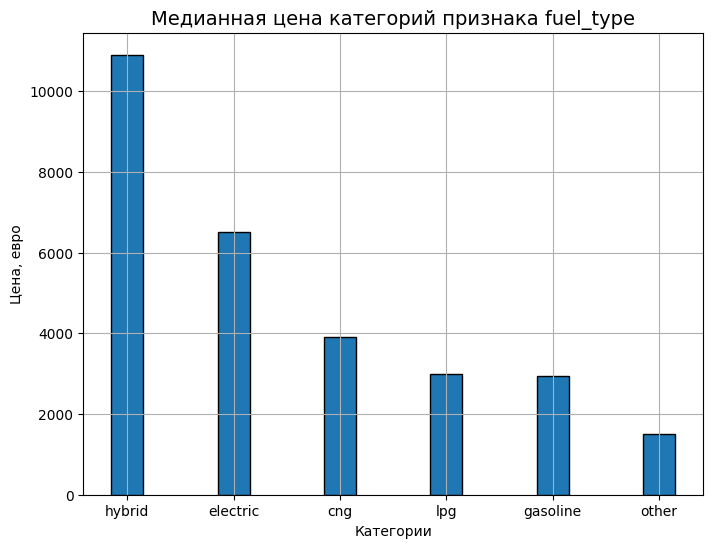

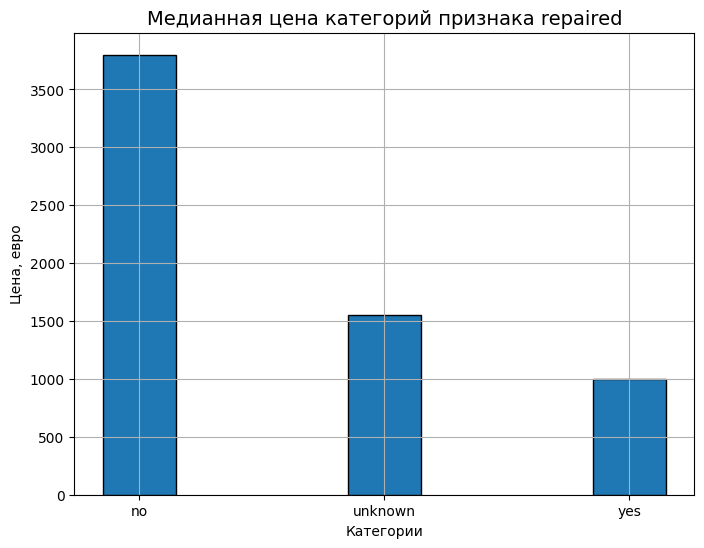

In [59]:
for column in ['gearbox', 'fuel_type', 'repaired']:
    
    index = (df
             .pivot_table(index=column, values='price', aggfunc='median')
             .sort_values(by='price', ascending=False)
             .index)
    values = (df
        .pivot_table(index=column, values='price', aggfunc='median')
        .sort_values(by='price', ascending=False)['price']
        .tolist())
    
    plt.figure(figsize=(8, 6))
    ax = plt.bar(index, values, width=0.3, edgecolor='black')
    plt.title(f'Медианная цена категорий признака {column}', fontsize=14)
    plt.xlabel('Категории')
    plt.ylabel('Цена, евро')
    plt.grid(True)
    plt.show()

+ Самым распространненым типом коробки передач является механическая, а дорогая автоматическая, что весьма логично.
+ С большим отрывом лидируют бензиновые автомобили благодаря нижней границе года регистрации авто, когда это был практически единственный вариант. Самыми дорогими являются современные технологичные гибридные и электромобили.
+ На вторичном рынке автоболей в большинстве представлены авто, не бывавшие в ремонте, они соответсвенно дороже.

Перед корреляционным анализом исключим все временные данные, месяц регистрации, т.к. они не являются информативными для нашей задачи. Также преобразуем год регистрации в возраст автомобиля для упрощения логики этого признака и сократим номер почтового индекса для уменьшений количества категорий признака.

In [60]:
cur_year = df['date_crawled'].dt.year.max()
df = df.rename(columns={'registration_year': 'age'})
df['age'] = cur_year - df['age']

In [61]:
len(df['postal_code'].unique())

8133

In [62]:
df['reg_postal'] = df['postal_code'] // 100
df['reg_postal'] = df['reg_postal'].astype('object')

In [63]:
len(df['reg_postal'].unique())

671

In [64]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code', 'registration_month'], axis=1)

In [65]:
df.head(2)

,price,vehicle_type,age,gearbox,power,model,kilometer,fuel_type,brand,repaired,reg_postal
0,480,sedan,23,manual,75,golf,150000,gasoline,volkswagen,unknown,704
1,18300,coupe,5,manual,190,a4,125000,gasoline,audi,yes,669


Проверим изменятся ли коэффициенты корреляции с таргетом входных признаков, если мы уберем из датасета все строки с заглушкой *unknown*.

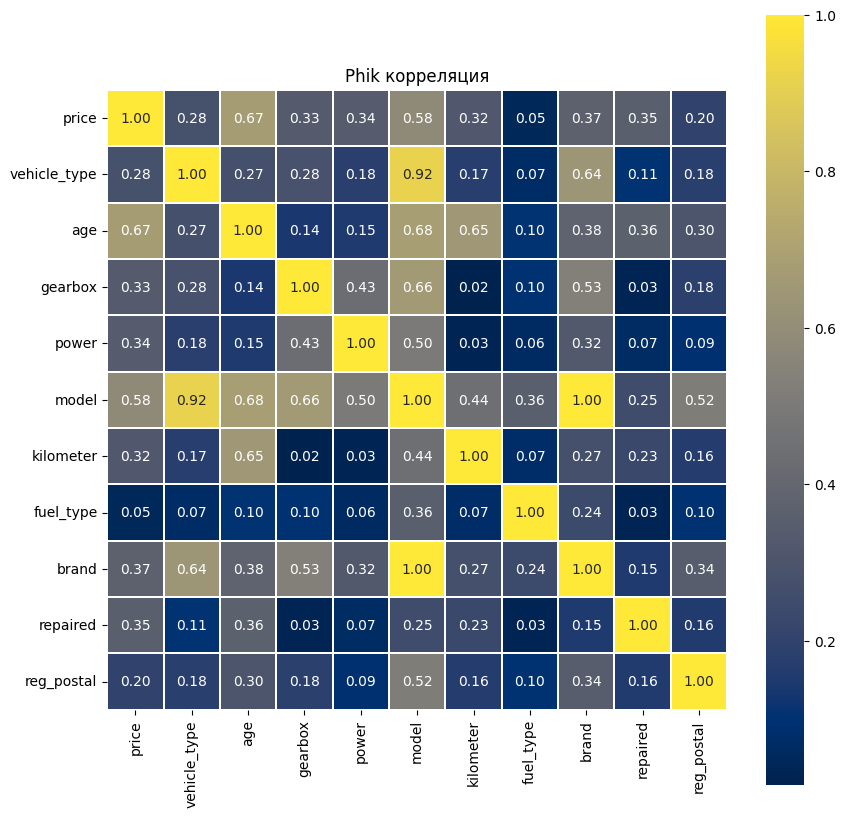

In [66]:
figsize = (10, 10)
fig = plt.subplots(figsize=figsize)
plt.title('Phik корреляция')
sns.heatmap(df
            .phik_matrix(interval_cols=num_cols), 
            annot=True, cmap='cividis', 
            linewidth=0.1,
            fmt='.2f',
            square=True)
plt.show()

+ Самую высокую корреляцию имеют тип кузова и модель автомобиля(0.9) и модель и марка(1), которые являются взаимозаменяемыми признаками, потому что каждая марка имеет уникальные модели. При подготовке данных для обучения модели лучше исключить марку, т.к. она меньше коррелирует с таргетом чем модель.
+ С целевым признаком больше всего коррелирует год регистрации авто(0.66), что отражает возраст, и модель автомобиля(0.58).
+ Корреляция меняется незначительно, если убрать строки с заглушкой, которую поставили при заполнении пропусков. Это означает, что можно ее оставить в тренировочной и тестовой выборке.

**Вывод:**

В этом разделе мы познакомились с предоставленными данными: изначально датасет имеет свыше 350 тыс. строк по 16 признакам, включая целевой `price`. Датасет имеет следующие проблемы: большое количество пропусков, неверный тип данных при считывании таблицы, аномальные значения признаков.

В ходе предобработки эти проблемы были устранены. Пропуски, замененные на маркер *unknown*  мы так оставим, т.к. эти категориальные признаки не имеют сильной корреляции с таргетом. Кроме этого сравнив два датасета с удаленными строками и просто с заглушкой обнаружили, что коэффициенты корреляции меняются незначительно. Аномальные значения были устранены путем фильтра на соответствующие признаки. Также удалили малозначимые для прогноза временные признаки и малоинформативный признак `NumberOfPictures`.

Среди количественных признаков наш целевой имеет распределение, отличное от нормального. Также отметим наличие выбросов для всех признаков. Признаки имеют нелинейную связь.

Однако судя по коэффициентам корреляции наибольшую связь с таргетом имеют категориальные признаки `age` и `model`, но даже между этими признаками эта связь несильная. Чего не скажешь про `model` и `brand` наличие которых указывает на частичную мултиколлинеарность и будет способстовать понижению эффективности модели линейной регрессии, но для дерева решений это не является проблемой. 




## Обучение моделей

Использовав полученную выше информацию, подготовим выборки для обучения и тестирования моделей. В качестве моделей будем выбирать из ансамблиевых моделей XGBoost, LightGBM, CatBoost, в качестве базовой рассмотрим TreeRegressor. Для более удобного способа подбора используем PipiLine.

### Подготовка выборки для обучения

Разделим данные на целевой(y) тренировочный/валидационный/тестовый и входные признаки(x).

In [67]:
RANDOM_STATE = 13

y = df['price']
X = df.drop(['price', 'brand'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.4,
    random_state=RANDOM_STATE
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, 
    y_test,
    test_size=0.5,
    random_state=RANDOM_STATE
)

Снова разделим данные на количественные и категориальные, т.к. у нас произошли исключения признаков:


In [68]:
num_columns = ['age', 'power', 'kilometer']
cat_columns = ['vehicle_type', 
               'gearbox', 
               'model', 
               'fuel_type', 
               'reg_postal', 
               'repaired']

Создадим Pipiline, который проведет стандартизацию для количественных данных и кодирование для категориальных.

In [69]:
data_preprocessor = ColumnTransformer(
    [
        ('target_enc', TargetEncoder(target_type="continuous"), cat_columns),
        ("numerical", "passthrough", num_columns)
        
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

### Подбор моделей

В качестве baseline модели будем использовать простое дерево решений, другими моделями будут LGBM и CatBoost, основанные на ансамбле деревьев с использованием градиентного бустинга.

Подберем гиперпараметры для первой модели дерева решений. Будем смотреть на топ-5 моделей, чтобы видеть изменение гиперпараметров в лучших моделях:

In [70]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 100),
        'models__max_features': range(2, 100),
        'models__min_samples_split': range(2, 100)
    }
]

start = time.time()

tree_descision_model = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

tree_descision_model.fit(X_train, y_train)

selection_time = round(time.time() - start, 5)
print(f'Продолжительность подбора модели {selection_time} c.')

rmse_train_tree = tree_descision_model.best_score_
print('Метрика RMSE для лучшей модели:\n', -rmse_train_tree)


result = pd.DataFrame(tree_descision_model.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'param_models', 'mean_test_score','params']].head(5)

Продолжительность подбора модели 13.79312 c.
Метрика RMSE для лучшей модели:
 1869.4174942529366


,rank_test_score,param_models,mean_test_score,params
8,1,DecisionTreeRegressor(random_state=13),-1869.417494,"{'models__min_samples_split': 92, 'models__max_features': 48, 'models__max_depth': 19, 'models': DecisionTreeRegressor(random_state=13)}"
0,2,DecisionTreeRegressor(random_state=13),-1877.094225,"{'models__min_samples_split': 96, 'models__max_features': 22, 'models__max_depth': 53, 'models': DecisionTreeRegressor(random_state=13)}"
1,3,DecisionTreeRegressor(random_state=13),-1877.873236,"{'models__min_samples_split': 80, 'models__max_features': 17, 'models__max_depth': 75, 'models': DecisionTreeRegressor(random_state=13)}"
3,4,DecisionTreeRegressor(random_state=13),-1882.359455,"{'models__min_samples_split': 82, 'models__max_features': 73, 'models__max_depth': 28, 'models': DecisionTreeRegressor(random_state=13)}"
9,5,DecisionTreeRegressor(random_state=13),-1882.456513,"{'models__min_samples_split': 57, 'models__max_features': 82, 'models__max_depth': 37, 'models': DecisionTreeRegressor(random_state=13)}"


Оставим модель с этими гиперпараметрами и преступим к подбору модели LGBMRegressor:

In [71]:
param_grid = [
    {
        'models': [LGBMRegressor()],
        'models__learning_rate': [0.1, 0.5, 0.8],  
        'models__n_estimators': [10, 50, 100], 
        'models__num_leaves': [31, 40, 50], 
        'models__max_depth': [3, 5, 15]
    }
]

start = time.time()

lgbm_model = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

lgbm_model.fit(X_train, y_train)

selection_time = round(time.time() - start, 5)
print(f'Продолжительность подбора модели {selection_time} c.')

rmse_train_lgbm = lgbm_model.best_score_
print('Метрика RMSE для лучшей модели:\n', -rmse_train_lgbm)

result = pd.DataFrame(lgbm_model.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'param_models', 'mean_test_score','params']].head(5)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 155398, number of used features: 9
[LightGBM] [Info] Start training from score 4637.133708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,rank_test_score,param_models,mean_test_score,params
6,1,LGBMRegressor(),-1743.643971,"{'models__num_leaves': 50, 'models__n_estimators': 100, 'models__max_depth': 5, 'models__learning_rate': 0.5, 'models': LGBMRegressor()}"
2,2,LGBMRegressor(),-1762.992350,"{'models__num_leaves': 50, 'models__n_estimators': 50, 'models__max_depth': 5, 'models__learning_rate': 0.5, 'models': LGBMRegressor()}"
8,3,LGBMRegressor(),-1796.845169,"{'models__num_leaves': 40, 'models__n_estimators': 50, 'models__max_depth': 15, 'models__learning_rate': 0.8, 'models': LGBMRegressor()}"
5,4,LGBMRegressor(),-1797.652771,"{'models__num_leaves': 31, 'models__n_estimators': 100, 'models__max_depth': 15, 'models__learning_rate': 0.8, 'models': LGBMRegressor()}"
4,5,LGBMRegressor(),-1804.517787,"{'models__num_leaves': 31, 'models__n_estimators': 50, 'models__max_depth': 15, 'models__learning_rate': 0.8, 'models': LGBMRegressor()}"


Перейдем к подбору последней - CatBoost:

In [72]:
param_grid = [
    {
        'models': [CatBoostRegressor(verbose=0)],
        'models__learning_rate': [0,1, 0.2, 0.4, 0.6, 0.8],  
        'models__depth': [6, 8, 10, 20], 
        'models__iterations': [10, 50, 100], 
        'models__l2_leaf_reg': [1, 3] 

    }
]

start = time.time()

cat_boost_model = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  
    n_jobs=-1,
    random_state=RANDOM_STATE,
)


cat_boost_model.fit(X_train, y_train)

selection_time = round(time.time() - start, 5)
print(f'Продолжительность подбора модели {selection_time} c.')

rmse_train_cat = cat_boost_model.best_score_
print('Метрика RMSE для лучшей модели:\n', -rmse_train_cat)

result = pd.DataFrame(cat_boost_model.cv_results_).sort_values('rank_test_score')
result[['rank_test_score', 'param_models', 'mean_test_score','params']].head(5)

Продолжительность подбора модели 54.42644 c.
Метрика RMSE для лучшей модели:
 1714.8276385115873


,rank_test_score,param_models,mean_test_score,params
9,1,<catboost.core.CatBoostRegressor object at 0x7130a16704c0>,-1714.827639,"{'models__learning_rate': 0.4, 'models__l2_leaf_reg': 3, 'models__iterations': 100, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7130a16704c0>}"
4,2,<catboost.core.CatBoostRegressor object at 0x7130a16704c0>,-1724.297044,"{'models__learning_rate': 0.6, 'models__l2_leaf_reg': 3, 'models__iterations': 100, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7130a16704c0>}"
7,3,<catboost.core.CatBoostRegressor object at 0x7130a16704c0>,-1742.023978,"{'models__learning_rate': 0.2, 'models__l2_leaf_reg': 3, 'models__iterations': 100, 'models__depth': 8, 'models': <catboost.core.CatBoostRegressor object at 0x7130a16704c0>}"
1,4,<catboost.core.CatBoostRegressor object at 0x7130a16704c0>,-1751.712352,"{'models__learning_rate': 0.8, 'models__l2_leaf_reg': 3, 'models__iterations': 50, 'models__depth': 10, 'models': <catboost.core.CatBoostRegressor object at 0x7130a16704c0>}"
8,5,<catboost.core.CatBoostRegressor object at 0x7130a16704c0>,-1792.971217,"{'models__learning_rate': 0.4, 'models__l2_leaf_reg': 3, 'models__iterations': 50, 'models__depth': 6, 'models': <catboost.core.CatBoostRegressor object at 0x7130a16704c0>}"


Настало время проверить выбранные модели на валидационной выборке.

## Анализ моделей

### Сравнение моделей

Оценим подобранные модели на валидационной выборке и сравним по метрике и времени обучения и предсказывания.

In [73]:
models = {'decision_tree_regressor': tree_descision_model,
          'lightgbm': lgbm_model, 
          'cat_boost': cat_boost_model
         }

results = {}

for name, model in models.items():
    
    start = time.time()
    predictions = model.predict(X_valid)
    predict_time = time.time() - start
    
    rmse = mean_squared_error(y_valid, predictions) ** 0.5
    
    results[name] = {
        'train_time': model.cv_results_['mean_fit_time'][model.best_index_],
        'predict_time': predict_time,
        'rmse_train': abs(model.cv_results_['mean_test_score'][model.best_index_]),
        'rmse_test': rmse,
        'rmse_difference': abs(model.cv_results_['mean_test_score'][model.best_index_]) - rmse
    }
    
df_results = pd.DataFrame(results).T
df_results

,train_time,predict_time,rmse_train,rmse_test,rmse_difference
decision_tree_regressor,1.505643,0.153764,1869.417494,1840.294934,29.122560
lightgbm,5.880618,0.269102,1743.643971,1730.354618,13.289353
cat_boost,10.025957,0.451376,1714.827639,1707.525717,7.301921


Наименьшее время для тренировки, как и следовало ожидать, требуется для дерева решений, ближайшая модель - LGBM, затем идет  CatBoost, причем разница между самой быстрой и медленной всего 3 с.

При расчете предсказания все модели уложились в одну секунду, по скорости места распределяются также, как и при обучении.

По метрике ансамбли показывают лучшее качество, причем наилучший результат у CatBoost, но не намного хуже у LGBM. Дерево решений немного хуже предсказывает, но все равно имеет значение метрики ниже порогового (2500) значения.

Мы видим небольшой разброс в моделях LGBM и CatBoost, больше отклонений наблюдаем у дерева. 

Учитывая назначение модели для применения в приложении, нам очень важно иметь минимальное время обучения и предсказания, ну и как требования к любой прогнозной модели следует добиваться минимизации ошибки. В свете этих требований подходят все модели, выберем модель с наилучшим качеством предсказаний - CatBoost.

### Анализ лучшей модели

Теперь, когда выбрали лучшую модель проверим ее на тестовой выборке и проанализируем остатки.

In [74]:
def analyze_residuals(y_test, predictions):
    
    ''' Функция строит гистограмму распределения остатков и график распределения остатков.
        На входе принимает тестовый и расчетный целевой показатели.'''
    print('Анализ остатков')
    print('=' * 80)
    residuals = y_test - predictions

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].hist(residuals)
    axes[0].grid(True)
    axes[0].set_title('Гистограмма распределения остатков', fontsize=16)
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество наблюдений')

    axes[1].scatter(y=residuals, x=predictions)
    axes[1].grid(True)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии', fontsize=16)
    
    plt.tight_layout()
    plt.show()

Анализ остатков


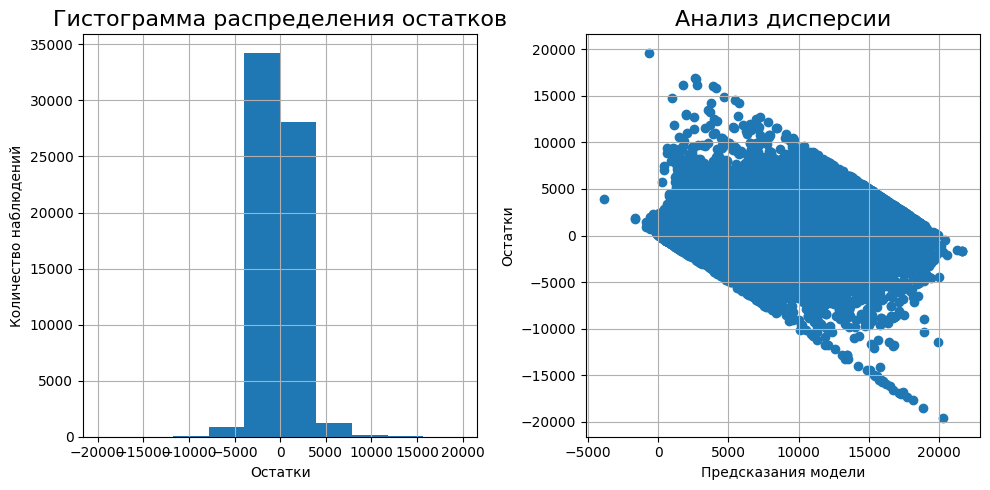

In [75]:
pred = cat_boost_model.predict(X_test)
analyze_residuals(y_test, pred)

Видим нормальное распределение ошибок. Дисперсия остатков указывает равное соотношение завышений\ занижений цен автомобилей. Настораживает факт, что есть отрицателбные прогнозы. Возможно, связано с сильной ассиметрией целевого признака. Преобразуем его с помощью логарифма для уменьшения разброса.

Анализ остатков


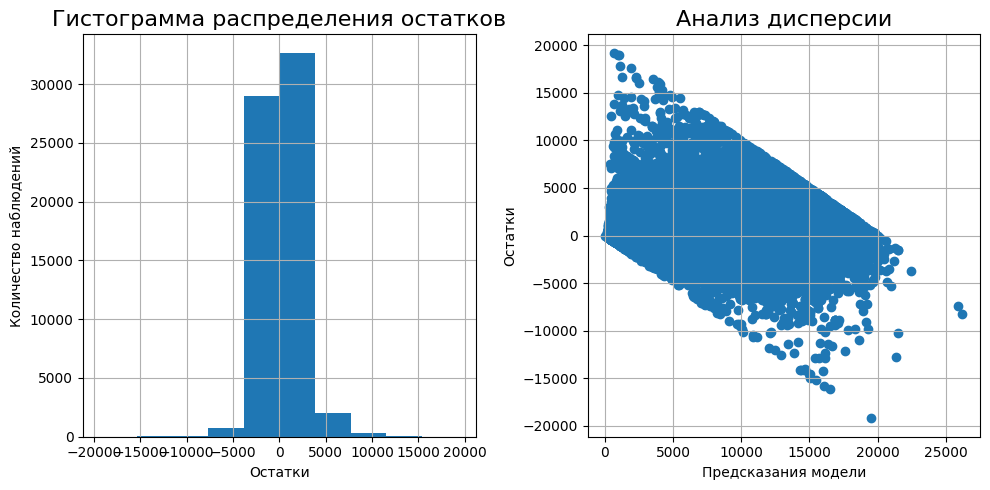

In [76]:
y_train_log = np.log1p(y_train)
cat_boost_model.fit(X_train, y_train_log)
y_pred_log = cat_boost_model.predict(X_test)
pred =np.expm1(y_pred_log)
analyze_residuals(y_test, pred)

Теперь модель делает исключительно положительные предсказания.

Посмотрим на распределние весов в выбранной модели.

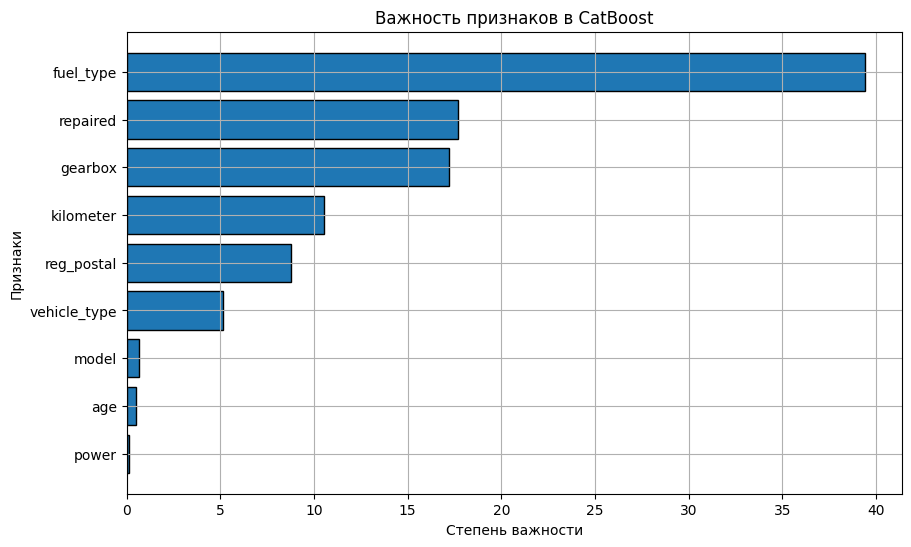

In [77]:
feature_importance = cat_boost_model.best_estimator_.named_steps['models'].get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values(by='importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'],edgecolor='black')
plt.xlabel('Степень важности')
plt.ylabel('Признаки')
plt.title('Важность признаков в CatBoost')
plt.grid()
plt.show()

Судя по графику, модель меньше всего использовала как критерий мощность, возраст авто и модель.

## Вывод

Этот проект был проведен для создания прогнозной составляющей приложения для сервиса по продаже автомобилей. Одной из функций этого приложения является прогнозирование стоимости автомобиля пользователя после введения данных о своем автомобиле. Т.к. это приложение то для удобства пользования необходимо, чтобы модель в реальном времени быстро отрабатывала: обучалась и совершала предсказание. Отсюда можно извлечь главные требования к прогнозной модели: минимизация времени обучения\предсказания, высокая точность прогнозов.

Исходные данные предсталяли собой таблицу, состоящую из 354369 строк и 16 признаков. Основными проблемами исходного датасета были пропуски, например, в столбце `repaired`, содержащем информацию о том, была ли машина в ремонте, остутствовало порядка 20% данных. Вероятно, что автовладельцы не отмечали это умышленно, однако стоимость автомобиля ремонтированного и нет отличается в 4 раза, поэтому данный признак улучшает качество предсказания. Было бы лучше для дальнейшего развития обучающей выборки, если этот признак станет обязательным в анкетировании. Также для предотвращения появления аномальных значений, например, в годе регистрации авто, можно ввести проверяющие условия при анкетировании, чтобы предотвратить ошибки и сделать данные более качественными.

Исследовательский анализ позволил нам узнать следующие полезные для выбора модели особенности данных:
+ таргет распределен ненормально;
+ количественные признаки имеют выбросы;
+ количественные признаки с целевым связаны нелинейно;
+ судя по коэффициентам корреляции наибольшую связь с таргетом имеют категориальные признаки `age` (0.68) и `model`(0.58), тем не менее численно это является слабой связью. Что касается сильной то она есть между признаками `model`-`vehicle_type`(0.9) ,  и `model`-`brand`(1), что является недопустимым в линейных моделях.

На основании этого было предпринято решение использовать нелинейные модели, устойчивые к выбросам, а именно стандартная Decision Tree Regressor и ансамбли деревьев с градиентным бустингом - LGBM и CatBoost.

После этапа подбора гиперпараметров модели были выбраны три наиболее эффективные модели, по одной на каждый тип. Все модели прошли обучение на полном предобработанном датасете. После этого были измерены время обучения и предсказания и качество прогноза оценено с помощью метрики RMSE. Самым оптимальным выбором для выполнения поставленных задач стала модель CatBoost: по скорости не сильно уступающая быстрейшей, но демострирующая наилучшие прогнозные свойства (RMSE = 1711) из выбранных моделей. 
